# Exploratory Data Analysis

Chapter 2

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

import utils
from utils import decorate
from distribution import Pmf, Cdf

## Loading and validation


In [57]:
import re

class FixedWidthVariables(object):
    """Represents a set of variables in a fixed width file."""

    def __init__(self, variables, index_base=0):
        """Initializes.

        variables: DataFrame
        index_base: are the indices 0 or 1 based?

        Attributes:
        colspecs: list of (start, end) index tuples
        names: list of string variable names
        """
        self.variables = variables

        # note: by default, subtract 1 from colspecs
        self.colspecs = variables[['start', 'end']] - index_base

        # convert colspecs to a list of pair of int
        self.colspecs = self.colspecs.astype(np.int).values.tolist()
        self.names = variables['name']

    def ReadFixedWidth(self, filename, **options):
        """Reads a fixed width ASCII file.

        filename: string filename

        returns: DataFrame
        """
        df = pd.read_fwf(filename,
                         colspecs=self.colspecs, 
                         names=self.names,
                         **options)
        return df


def ReadStataDct(dct_file, **options):
    """Reads a Stata dictionary file.

    dct_file: string filename
    options: dict of options passed to open()

    returns: FixedWidthVariables object
    """
    type_map = dict(byte=int, int=int, long=int, float=float, 
                    double=float, numeric=float)

    var_info = []
    with open(dct_file, **options) as f:
        for line in f:
            match = re.search( r'_column\(([^)]*)\)', line)
            if not match:
                continue
            start = int(match.group(1))
            t = line.split()
            vtype, name, fstring = t[1:4]
            name = name.lower()
            if vtype.startswith('str'):
                vtype = str
            else:
                vtype = type_map[vtype]
            long_desc = ' '.join(t[4:]).strip('"')
            var_info.append((start, vtype, name, fstring, long_desc))
            
    columns = ['start', 'type', 'name', 'fstring', 'desc']
    variables = pd.DataFrame(var_info, columns=columns)

    # fill in the end column by shifting the start column
    variables['end'] = variables.start.shift(-1)
    variables.loc[len(variables)-1, 'end'] = 0

    dct = FixedWidthVariables(variables, index_base=1)
    return dct

def read_gss(dirname):
    """Reads GSS files from the given directory.
    
    dirname: string
    
    returns: DataFrame
    """
    dct = ReadStataDct(dirname + '/GSS.dct')
    gss = dct.ReadFixedWidth(dirname + '/GSS.dat.gz',
                             compression='gzip')
    return gss

In [58]:
gss = read_gss('gss_eda')
print(gss.shape)
gss.head()

(62466, 97)


,postlife,life,helpful,fair,trust,conclerg,coneduc,confed,conpress,conjudge,...,natenvir,natheal,natcity,natcrime,natdrug,nateduc,natrace,natarms,nataid,attend
0,0,0,2,2,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,0,0,1,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
2,0,0,2,1,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,2,2,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,2,2,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
def replace_invalid(df):
    df.realinc.replace([0], np.nan, inplace=True)                  
    df.educ.replace([98,99], np.nan, inplace=True)
    df.age.replace([98, 99], np.nan, inplace=True)               # 89 means 89 or older
    df.cohort.replace([9999], np.nan, inplace=True)

replace_invalid(gss)

In [60]:
variables = ['id_', 'year', 'sex', 'age', 'cohort', 'race', 'educ', 'realinc', 'wtssall', ]

subset = gss[variables]
subset.head()

,id_,year,sex,age,cohort,race,educ,realinc,wtssall
0,1,1972,2,23.0,1949.0,1,16.0,18951.0,0.4446
1,2,1972,1,70.0,1902.0,1,10.0,24366.0,0.8893
2,3,1972,2,48.0,1924.0,1,12.0,24366.0,0.8893
3,4,1972,2,27.0,1945.0,1,17.0,30458.0,0.8893
4,5,1972,2,61.0,1911.0,1,12.0,50763.0,0.8893


In [61]:
subset.to_hdf('gss.hdf5', 'gss')

In [62]:
%time gss = pd.read_hdf('gss.hdf5', 'gss')

CPU times: user 16 ms, sys: 16 ms, total: 32 ms
Wall time: 26.9 ms


In [63]:
np.random.seed(19)
gss = utils.resample_rows_weighted(gss, 'wtssall')

In [64]:
gss['year'].describe()

count    62466.000000
mean      1994.044232
std         12.950645
min       1972.000000
25%       1983.000000
50%       1994.000000
75%       2006.000000
max       2016.000000
Name: year, dtype: float64

In [65]:
gss['sex'].describe()

count    62466.000000
mean         1.546041
std          0.497880
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          2.000000
Name: sex, dtype: float64

In [11]:
gss['age'].describe()

count    62270.000000
mean        44.594347
std         17.070142
min         18.000000
25%         30.000000
50%         43.000000
75%         57.000000
max         89.000000
Name: age, dtype: float64

In [12]:
gss['cohort'].describe()

count    62270.000000
mean      1949.387169
std         20.810783
min       1883.000000
25%       1935.000000
50%       1951.000000
75%       1964.000000
max       1998.000000
Name: cohort, dtype: float64

In [13]:
gss['race'].describe()

count    62466.000000
mean         1.251145
std          0.553372
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          3.000000
Name: race, dtype: float64

In [14]:
gss['educ'].describe()

count    62327.000000
mean        12.827202
std          3.128491
min          0.000000
25%         12.000000
50%         12.000000
75%         15.000000
max         20.000000
Name: educ, dtype: float64

In [15]:
gss['realinc'].describe()

count     55636.000000
mean      34829.210636
std       30826.747119
min         234.000000
25%       13750.000000
50%       26411.000000
75%       43426.000000
max      162607.000000
Name: realinc, dtype: float64

In [16]:
gss['wtssall'].describe()

count    62466.000000
mean         1.211513
std          0.580101
min          0.391825
25%          0.918400
50%          1.062100
75%          1.515500
max          8.739876
Name: wtssall, dtype: float64

In [17]:
class Pmf(pd.Series):
    
    def __init__(self, seq, name='Pmf', normalize=True):
        series = pd.Series(seq).value_counts().sort_index()
        super().__init__(series, name=name)
        if normalize:
            self.normalize()

    @property
    def qs(self):
        return self.index

    @property
    def ps(self):
        return self.values

    def __call__(self, qs):
        return self.get(qs, 0)

    def normalize(self):
        self /= self.sum()

    def bar(self, **options):
        plt.bar(self.index, self.values, label=self.name, **options)

    def plot(self, **options):
        plt.plot(self.index, self.values, label=self.name, **options)


In [18]:
from scipy.interpolate import interp1d

class Cdf(pd.Series):

    def __init__(self, seq, name='Cdf'):
        pmf = Pmf(seq)
        super().__init__(pmf.cumsum(), name=name)

    @property
    def qs(self):
        return self.index

    @property
    def ps(self):
        return self.values

    @property
    def forward(self):
        return interp1d(self.qs, self.ps,
                        kind='previous',
                        assume_sorted=True,
                        bounds_error=False,
                        fill_value=(0,1))

    @property
    def inverse(self):
        return interp1d(self.ps, self.qs,
                        kind='next',
                        assume_sorted=True,
                        bounds_error=False,
                        fill_value=(self.qs[0], np.nan))

    def __call__(self, qs):
        return self.forward(qs)

    def percentile_rank(self, qs):
        return self.forward(qs) * 100

    def percentile(self, percentile_ranks):
        return self.inverse(percentile_ranks / 100)

    def step(self, **options):
        underride(options, where='post')
        plt.step(self.index, self.values, label=self.name, **options)

    def plot(self, **options):
        plt.plot(self.index, self.values, label=self.name, **options)

In [19]:
race = gss['race']

race.value_counts().sort_index()

1    50468
2     8308
3     3690
Name: race, dtype: int64

In [20]:
pmf_race = Pmf(race, name='race', normalize=False)
pmf_race

1    50468
2     8308
3     3690
Name: race, dtype: int64

In [21]:
pmf_race.qs

Int64Index([1, 2, 3], dtype='int64')

In [22]:
pmf_race.ps

array([50468,  8308,  3690])

In [23]:
pmf_race(1)

50468

In [24]:
pmf_race(4)

0

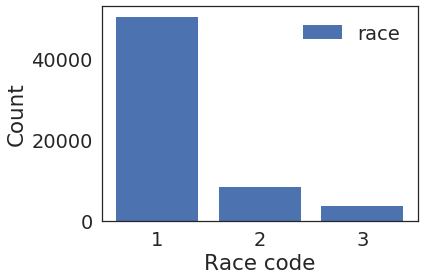

In [25]:
pmf_race.bar()
decorate(xlabel='Race code', ylabel='Count')

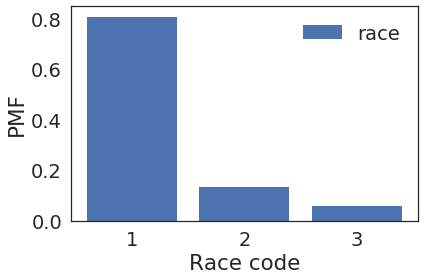

In [26]:
pmf_race.normalize()
pmf_race.bar()
decorate(xlabel='Race code', ylabel='PMF')

In [27]:
pmf_race(2)

0.13300035219159223

In [28]:
age = gss['age']
pmf_age = Pmf(age, name='age')

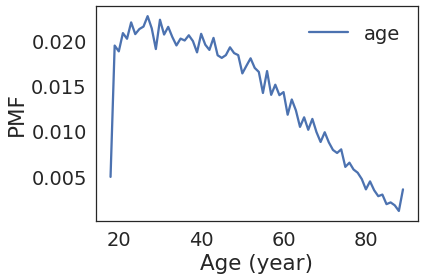

In [29]:
pmf_age.plot()
decorate(xlabel='Age (year)', ylabel='PMF')

In [30]:
def underride(d, **options):
    """Add key-value pairs to d only if key is not in d.

    d: dictionary
    options: keyword args to add to d
    """
    for key, val in options.items():
        d.setdefault(key, val)

    return d

In [31]:
cdf_age = Cdf(age, name='Age')

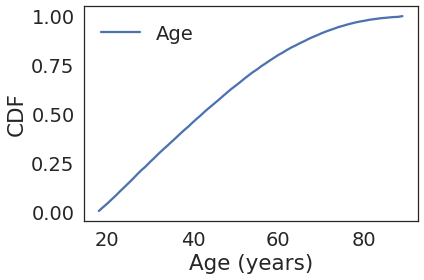

In [32]:
cdf_age.plot()
decorate(xlabel='Age (years)', ylabel='CDF')

In [33]:
cdf_age.forward(51)

array(0.66200418)

In [34]:
cdf_age.inverse(0.5)

array(43.)

### Variable `realinc`

Family income on 1972-2006 surveys in constant dollars (base = 1986)

https://gssdataexplorer.norc.org/variables/5198/vshow


In [35]:
income = gss['realinc']
pmf_income = Pmf(income, name='income')

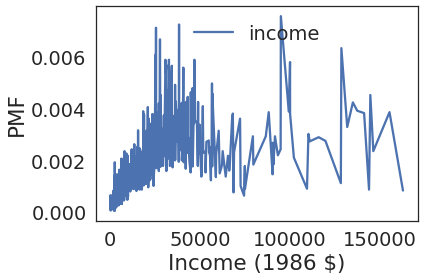

In [36]:
pmf_income.plot()
decorate(xlabel='Income (1986 $)', ylabel='PMF')

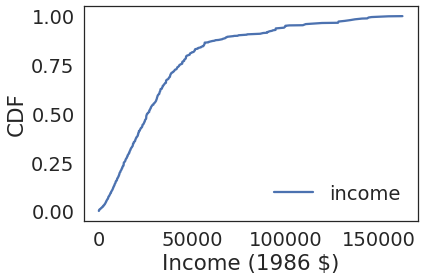

In [37]:
cdf_income = Cdf(income, name='income')
cdf_income.plot()
decorate(xlabel='Income (1986 $)', ylabel='CDF')

In [38]:
female = gss['sex'] == 2
male = gss['sex'] == 1

In [39]:
female.mean()

0.5435436877661448

In [40]:
male.mean()

0.45645631223385524